In [1]:
# check the GPU information  

!nvidia-smi

Tue Jun  6 14:41:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Library**

In [2]:
# import the library

import numpy as np  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math
import os
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation 

**Data Gathering and Prepocessing**

In [3]:
# remove dataset in a new runtimr (if already run the clone code previously) 
# ignore if no CycleMe folder in Colab Files

try:
    !rm -rf '/content/CycleMe'
    print("% s removed successfully")
except OSError as error:
    print(error)
    print("File is empty, can not be removed!")

% s removed successfully


In [4]:
# clone data from github

!git clone https://github.com/Cycle-Me/machine_learning.git

Cloning into 'machine_learning'...
remote: Enumerating objects: 7339, done.
remote: Counting objects: 100% (710/710), done.
remote: Compressing objects: 100% (692/692), done.
remote: Total 7339 (delta 22), reused 702 (delta 18), pack-reused 6629
Receiving objects: 100% (7339/7339), 253.67 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Updating files: 100% (9330/9330), done.


In [5]:
# investigating unsupported image files

from pathlib import Path
import imghdr

DIR = '/content/machine_learning/CycleMeDataset'
image_extensions = [".png", ".jpg"]  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DIR).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

/content/machine_learning/CycleMeDataset/Plastic/plast (12).jpg is not an image
/content/machine_learning/CycleMeDataset/Carton/cart (15).jpg is not an image
/content/machine_learning/CycleMeDataset/Organic Waste/org (22).jpg is not an image
/content/machine_learning/CycleMeDataset/Organic Waste/org (183).jpg is not an image
/content/machine_learning/CycleMeDataset/Textiles/text (29).jpg is not an image
/content/machine_learning/CycleMeDataset/Textiles/text (19).jpg is not an image
/content/machine_learning/CycleMeDataset/Textiles/text (295).jpg is not an image
/content/machine_learning/CycleMeDataset/Textiles/text (199).jpg is not an image
/content/machine_learning/CycleMeDataset/Styrofoam/STYROFOAM (8).jpg is a webp, not accepted by TensorFlow
/content/machine_learning/CycleMeDataset/Styrofoam/STYROFOAM (9).jpg is a webp, not accepted by TensorFlow
/content/machine_learning/CycleMeDataset/Styrofoam/STYROFOAM (4).jpg is a webp, not accepted by TensorFlow
/content/machine_learning/Cycl

In [6]:
# delete unsupported image files

img_link=list(Path(DIR).glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10) #The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

Total 83 pcs image delete from Dataset


In [7]:
# load the data

DIR = "/content/machine_learning/CycleMeDataset"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 4551 files belonging to 8 classes.
Using 4096 files for training.
Found 4551 files belonging to 8 classes.
Using 455 files for validation.
['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Styrofoam', 'Textiles']


In [8]:
# display the number of images on each class

classes = ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Styrofoam', 'Textiles']
numData = 0
for label in classes:
    directory = os.path.join(DIR, label)
    lengthDir = len(os.listdir(directory))
    print("Images of label \"" + label + "\":\t\t",lengthDir)
    numData = numData + lengthDir
print('Total images : \t',numData)

Images of label "Aluminium":		 598
Images of label "Carton":		 547
Images of label "Glass":		 585
Images of label "Organic Waste":		 542
Images of label "Paper and Cardboard":		 601
Images of label "Plastic":		 593
Images of label "Styrofoam":		 511
Images of label "Textiles":		 574
Total images : 	 4551


**Model Training**

In [9]:
# create the model

baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), 
                                                   weights='imagenet', 
                                                   include_top=False, 
                                                   classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45)(last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(100, 
                          activation = tf.keras.activations.elu, 
                          kernel_regularizer=tf.keras.regularizers.l1(0.045), 
                          activity_regularizer=tf.keras.regularizers.l1(0.045),  
                          kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dense(85, activation = tf.keras.activations.elu)(x)
x = tf.keras.layers.Dropout(0.45)(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, 
                    validation_data=test_dataset, 
                    epochs=epochs, 
                    callbacks=[])

12683000/12683000 [==============================] - 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


32/32 [==============================] - 32s 520ms/step - loss: 102.8241 - accuracy: 0.5981 - val_loss: 49.8458 - val_accuracy: 0.8374
Epoch 2/50
32/32 [==============================] - 15s 376ms/step - loss: 25.2160 - accuracy: 0.8259 - val_loss: 8.5537 - val_accuracy: 0.8505
Epoch 3/50
32/32 [==============================] - 13s 353ms/step - loss: 4.5672 - accuracy: 0.8386 - val_loss: 2.7717 - val_accuracy: 0.8549
Epoch 4/50
32/32 [==============================] - 14s 368ms/step - loss: 2.4511 - accuracy: 0.8516 - val_loss: 2.1227 - val_accuracy: 0.8681
Epoch 5/50
32/32 [==============================] - 15s 412ms/step - loss: 2.0489 - accuracy: 0.8762 - val_loss: 1.8450 - val_accuracy: 0.8967
Epoch 6/50
32/32 [==============================] - 14s 361ms/step - loss: 1.8397 - accuracy: 0.9004 - val_loss: 1.7238 - val_accuracy: 0.9033
Epoch 7/50
32/32 [==============================] - 14s 373ms/step - loss: 1.7003 - accuracy: 0.9170 - val_loss: 1.6258 - val_accuracy: 0.9187
Epoch 

In [10]:
# save the model to h5 format

model.save("/content/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
# save the model to json format

from tensorflow.keras.models import model_from_json
model_in_json = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_in_json)

**Model Evaluation**

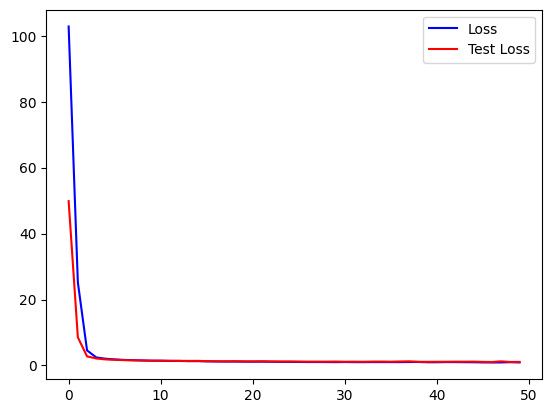

In [12]:
# loss plot

plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

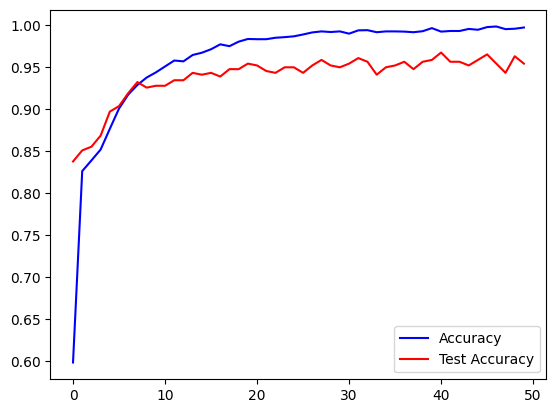

In [13]:
# accuracy plot

plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

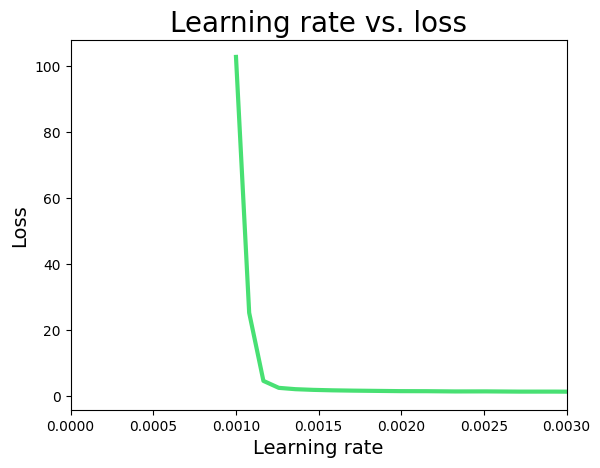

In [14]:
# learning rate vs. los plot

plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 2s 2s/step
[5.0348025e-03 9.9677223e+01 2.3542258e-03 2.7185499e-03 2.9291457e-01
 1.1912782e-02 4.5856354e-03 3.2514539e-03] 
 ['Aluminium', 'Carton', 'Glass', 'Organic Waste', 'Paper and Cardboard', 'Plastic', 'Styrofoam', 'Textiles']
Prediction:  Carton 99.67722296714783%


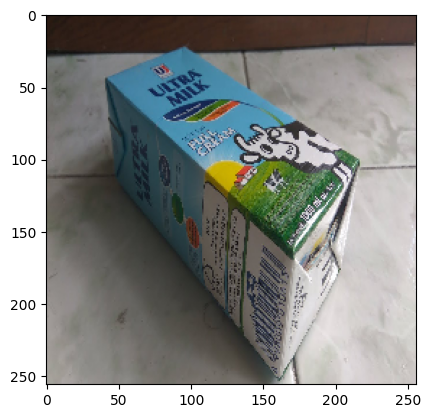

In [15]:
# try the image prediction

import requests

# alumunium
# img_data = requests.get("https://d1vbn70lmn1nqe.cloudfront.net/prod/wp-content/uploads/2022/08/03085011/Alat-Masak-Aluminium-Berbahaya-bagi-Kesehatan_-Kenali-Faktanya.jpg").content
# carton 
img_data = requests.get("https://i.ytimg.com/vi/RcDCr0ggZZo/maxresdefault.jpg").content
# paper and cardboard
#img_data = requests.get("https://4.bp.blogspot.com/-B1R5UYoNDhQ/UtgUPnHng-I/AAAAAAAAAoA/JMYUUGN1xi4/s1600/tumpukan+kertas.jpg").content

with open('img.jpg', 'wb') as handler:
    handler.write(img_data)

path = "/content/img.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

In [16]:
# move file txt outside the dataset folder

file_source2 = '/content/machine_learning/CycleMeDataset/'
file_destination2 = '/content/machine_learning/'

get_files2 = os.listdir(file_source2)

shutil.move(file_source2 + 'problem_1.txt', file_destination2)

'/content/machine_learning/problem_1.txt'

In [17]:
# create function to display confusion matrix 

def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/machine_learning/CycleMeDataset"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0) 

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

1/1 [==============================] - 0s 25ms/step


<Figure size 1000x1000 with 0 Axes>

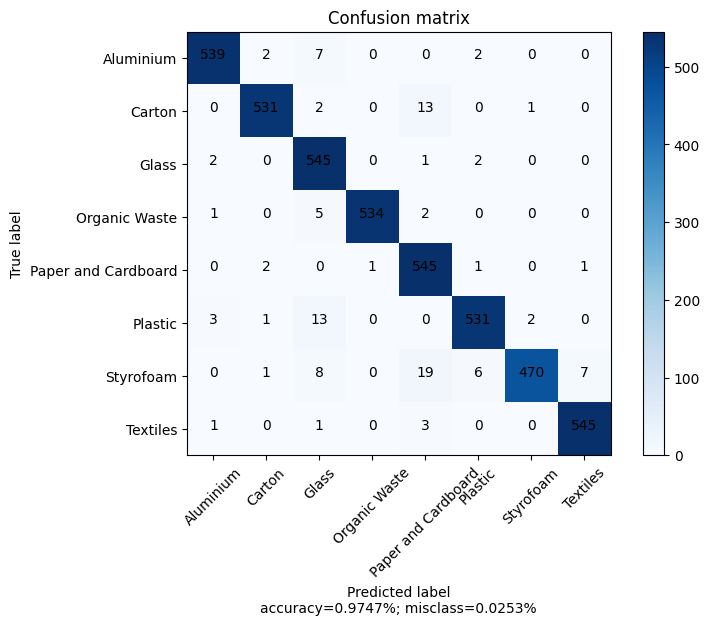

In [18]:
# display the confusion matrix 

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)